In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration: Use MPS if available (for M1 chips), else check for CUDA, else CPU.
if torch.backends.mps.is_available():
    device = torch.device("mps")
    num_workers = 0  # For MPS, it's best to set num_workers=0 to avoid multiprocessing issues.
elif torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 2
else:
    device = torch.device("cpu")
    num_workers = 0

print("Using device:", device)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: mps


In [3]:
# =============================================================================
# Improved VGG16 for CIFAR-100 with BatchNorm and AdaptiveAvgPool
# =============================================================================
class VGG16_CIFAR(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16_CIFAR, self).__init__()
        self.features = nn.Sequential(
            # Block 1: conv - bn - relu - conv - bn - relu - pool
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16

            # Block 2: conv - bn - relu - conv - bn - relu - pool
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8

            # Block 3: conv - bn - relu - conv - bn - relu - conv - bn - relu - pool
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8 -> 4

            # Block 4: conv - bn - relu - conv - bn - relu - conv - bn - relu - pool
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4 -> 2

            # Block 5: conv - bn - relu - conv - bn - relu - conv - bn - relu
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # Instead of a final pooling, use AdaptiveAvgPool2d for fixed output size.
            nn.AdaptiveAvgPool2d((1, 1))
        )
        # Classifier: a single linear layer
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = self.classifier(x)
        return x


In [4]:
# =============================================================================
# Data Preparation: CIFAR-100 with Augmentation and Normalization
# =============================================================================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=num_workers)

classes = trainset.classes  # For display purposes

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# =============================================================================
# Model, Loss Function, Optimizer, and Scheduler
# =============================================================================
model = VGG16_CIFAR(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [6]:
# =============================================================================
# Training Function
# =============================================================================
def train_model(model, trainloader, criterion, optimizer, scheduler, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        scheduler.step()
        print(f"Epoch: {epoch+1:3d} | Loss: {running_loss/len(trainloader):.4f} | Accuracy: {100.*correct/total:5.2f}%")
    
    print("Finished Training")


In [7]:
# =============================================================================
# Evaluation Function
# =============================================================================
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = test_loss / len(testloader)
    accuracy = 100. * correct / total
    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [8]:
# =============================================================================
# Interactive Prediction Function
# =============================================================================
def interactive_predict(model, dataset):
    """
    Prompts the user for an image index and displays the corresponding image,
    ground truth, and predicted class.
    """
    try:
        index = int(input("Enter an image index (0 to {}): ".format(len(dataset)-1)))
    except ValueError:
        print("Invalid input. Please enter an integer.")
        return
    
    if index < 0 or index >= len(dataset):
        print("Index out of range.")
        return
    
    image, label = dataset[index]
    model.eval()
    with torch.no_grad():
        input_img = image.unsqueeze(0).to(device)
        outputs = model(input_img)
        predicted_label = outputs.argmax(dim=1).item()
    
    # Unnormalize for display
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img_np = image.numpy().transpose((1, 2, 0))
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    plt.figure()
    plt.imshow(img_np)
    plt.title(f"Ground Truth: {classes[label]}\nPredicted: {classes[predicted_label]}")
    plt.axis('off')
    plt.show()
    
    print(f"Ground Truth Label: {classes[label]}")
    print(f"Predicted Label: {classes[predicted_label]}")


Starting Training...
Epoch:   1 | Loss: 4.1730 | Accuracy:  4.79%
Epoch:   2 | Loss: 3.7557 | Accuracy:  9.92%
Epoch:   3 | Loss: 3.4683 | Accuracy: 14.59%
Epoch:   4 | Loss: 3.1590 | Accuracy: 19.65%
Epoch:   5 | Loss: 2.8756 | Accuracy: 24.58%
Epoch:   6 | Loss: 2.6564 | Accuracy: 29.52%
Epoch:   7 | Loss: 2.4635 | Accuracy: 33.54%
Epoch:   8 | Loss: 2.3294 | Accuracy: 36.95%
Epoch:   9 | Loss: 2.2282 | Accuracy: 39.28%
Epoch:  10 | Loss: 2.1316 | Accuracy: 41.61%
Epoch:  11 | Loss: 2.0557 | Accuracy: 43.42%
Epoch:  12 | Loss: 2.0005 | Accuracy: 44.75%
Epoch:  13 | Loss: 1.9373 | Accuracy: 46.46%
Epoch:  14 | Loss: 1.8858 | Accuracy: 47.83%
Epoch:  15 | Loss: 1.8361 | Accuracy: 49.29%
Epoch:  16 | Loss: 1.8037 | Accuracy: 49.97%
Epoch:  17 | Loss: 1.7768 | Accuracy: 50.75%
Epoch:  18 | Loss: 1.7458 | Accuracy: 51.61%
Epoch:  19 | Loss: 1.7173 | Accuracy: 52.42%
Epoch:  20 | Loss: 1.6907 | Accuracy: 53.23%
Epoch:  21 | Loss: 1.6675 | Accuracy: 53.51%
Epoch:  22 | Loss: 1.6377 | Accura

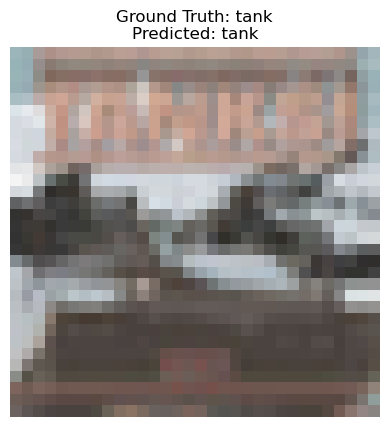

Ground Truth Label: tank
Predicted Label: tank


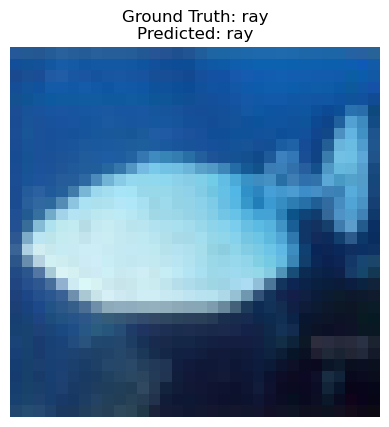

Ground Truth Label: ray
Predicted Label: ray


In [9]:
# =============================================================================
# Main Execution
# =============================================================================
if __name__ == "__main__":
    print("Starting Training...")
    train_model(model, trainloader, criterion, optimizer, scheduler, epochs=100)
    
    print("\nEvaluating on test set...")
    evaluate_model(model, testloader, criterion)
    
    # Interactive prediction loop (adjust or remove if running in non-interactive environment)
    while True:
        interactive_predict(model, testset)
        cont = input("Do you want to predict another image? (y/n): ")
        if cont.lower() != 'y':
            break